In [1]:
!pip install transformers datasets torch scikit-learn pandas matplotlib seaborn tqdm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
print("PyTorch version:", torch.__version__)
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


PyTorch version: 2.8.0+cu126
GPU available: True
GPU name: Tesla T4


In [4]:
import os, pandas as pd

base = "/content/drive/MyDrive/Machine_Learning_Mini_Project"


for name in ["English_train_lpc.xlsx", "English_valid_lpc.xlsx", "English_test_lpc.xlsx"]:
    path = os.path.join(base, name)
    print(f"\nChecking: {path}")
    print("Exists:", os.path.exists(path))
    if os.path.exists(path):
        df = pd.read_excel(path)
        print("Rows:", len(df), "| Columns:", df.columns.tolist())
        print(df.head(2))


Checking: /content/drive/MyDrive/Machine_Learning_Mini_Project/English_train_lpc.xlsx
Exists: True
Rows: 36877 | Columns: ['labels', 'text']
      labels                                               text
0  Elections    ( Image Source : PTI )Congress releases a li...
1       Auto  Let us talk regarding performance Here Honda h...

Checking: /content/drive/MyDrive/Machine_Learning_Mini_Project/English_valid_lpc.xlsx
Exists: True
Rows: 4610 | Columns: ['labels', 'text']
      labels                                               text
0  Elections   However, BJP had won two assembly bypolls and...
1     Health   Anil Arora, chairman of the Institute of Live...

Checking: /content/drive/MyDrive/Machine_Learning_Mini_Project/English_test_lpc.xlsx
Exists: True
Rows: 4610 | Columns: ['labels', 'text']
          labels                                               text
0     Technology  Related StoriesTop StoriesBy: ABP News Bureau ...
1  Entertainment   Early estimates from Sacnilkcom indica

In [5]:
import pandas as pd
import os

# Define paths
base_path = "/content/drive/MyDrive/Machine_Learning_Mini_Project"

train_path = os.path.join(base_path, "English_train_lpc.xlsx")
valid_path = os.path.join(base_path, "English_valid_lpc.xlsx")
test_path  = os.path.join(base_path, "English_test_lpc.xlsx")

# Read Excel files
train_df = pd.read_excel(train_path)
val_df   = pd.read_excel(valid_path)
test_df  = pd.read_excel(test_path)

# Show few samples
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)

train_df.head()


Train shape: (36877, 2)
Validation shape: (4610, 2)
Test shape: (4610, 2)


,labels,text
0,Elections,( Image Source : PTI )Congress releases a li...
1,Auto,Let us talk regarding performance Here Honda h...
2,Lifestyle,Related StoriesTop StoriesBy: ABP News Bureau ...
3,India,"""I agreed to this request too and instructed m..."
4,Business,"India-Russia relations remain very steady, re..."


In [6]:
import re

def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"<.*?>", "", text)    # remove HTML tags
    text = re.sub(r"\s+", " ", text)     # collapse spaces
    return text.strip()

for df in [train_df, val_df, test_df]:
    df['text'] = df['text'].apply(clean_text)


In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

train_df['label_id'] = le.fit_transform(train_df['labels'])
val_df['label_id']   = le.transform(val_df['labels'])
test_df['label_id']  = le.transform(test_df['labels'])

num_classes = len(le.classes_)
print("Number of unique classes:", num_classes)
print("Classes:", list(le.classes_))


Number of unique classes: 13
Classes: ['Auto', 'Business', 'Education', 'Elections', 'Entertainment', 'Health', 'India', 'Lifestyle', 'Science', 'Sports', 'Technology', 'World', nan]


<Axes: title={'center': 'Label Distribution - Train'}, xlabel='labels'>

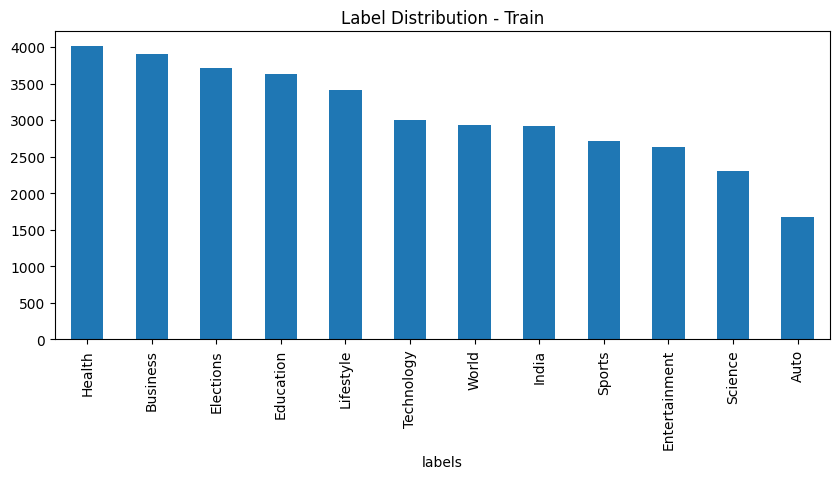

In [8]:
train_df['labels'].value_counts().plot(kind='bar', figsize=(10,4), title='Label Distribution - Train')


In [9]:
print("Null values per column:\n", train_df.isnull().sum())
print("Empty text rows:", (train_df['text'].str.strip() == '').sum())


Null values per column:
 labels      20
text         0
label_id     0
dtype: int64
Empty text rows: 0


In [10]:
# Remove rows where label is NaN
train_df = train_df.dropna(subset=['labels'])
val_df = val_df.dropna(subset=['labels'])
test_df = test_df.dropna(subset=['labels'])

print("Train shape after dropping NaN labels:", train_df.shape)
print("Validation shape after dropping NaN labels:", val_df.shape)
print("Test shape after dropping NaN labels:", test_df.shape)


# Re-check unique classes (should now be 12)
num_classes = len(train_df['labels'].unique())
print("Unique class count after cleaning:", num_classes)

Train shape after dropping NaN labels: (36857, 3)
Validation shape after dropping NaN labels: (4606, 3)
Test shape after dropping NaN labels: (4608, 3)
Unique class count after cleaning: 12


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['label_id'] = le.fit_transform(train_df['labels'])
val_df['label_id']   = le.transform(val_df['labels'])
test_df['label_id']  = le.transform(test_df['labels'])

num_classes = len(le.classes_)
print("Final classes:", list(le.classes_))

Final classes: ['Auto', 'Business', 'Education', 'Elections', 'Entertainment', 'Health', 'India', 'Lifestyle', 'Science', 'Sports', 'Technology', 'World']


/tmp/ipython-input-3655342078.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['label_id']  = le.transform(test_df['labels'])


In [12]:
from transformers import AutoTokenizer

model_name = "bert-base-uncased"  # main English model
tokenizer = AutoTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
from datasets import Dataset

# Convert DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df[['text', 'label_id']])
val_dataset   = Dataset.from_pandas(val_df[['text', 'label_id']])
test_dataset  = Dataset.from_pandas(test_df[['text', 'label_id']])

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=256
    )

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset   = val_dataset.map(tokenize_function, batched=True)
test_dataset  = test_dataset.map(tokenize_function, batched=True)

# Rename label_id column to 'labels' for Trainer API
train_dataset = train_dataset.rename_column("label_id", "labels")
val_dataset   = val_dataset.rename_column("label_id", "labels")
test_dataset  = test_dataset.rename_column("label_id", "labels")

# Set tensor format
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/36857 [00:00<?, ? examples/s]

Map:   0%|          | 0/4606 [00:00<?, ? examples/s]

Map:   0%|          | 0/4608 [00:00<?, ? examples/s]

In [14]:
print(train_dataset[0])
print("Decoded text sample:", tokenizer.decode(train_dataset[0]['input_ids']))


{'labels': tensor(3), 'input_ids': tensor([  101,  1006,  3746,  3120,  1024, 13866,  2072,  1007,  3519,  7085,
         1037,  2862,  1997,  2382,  5347,  2005,  1996,  9046,  2602,  1999,
        10381, 12707,  7315, 13484, 27487,  1038,  6979, 10374,  2232,  4524,
        16001,  2000,  5049,  2013,  6986,  2319,  1010,  4112,  4642, 24529,
         5960,  2139,  2080,  2013,  2572,  5638,  2912,  5311, 27263,  2102,
         9148, 12079,  9006,  1013,  1043,  2100,  9148,  2094, 13213,  5831,
         3736,  2130,  2004,  1996,  2283, 11807,  2049,  8069,  2006,  2214,
         1011, 25309,  2015,  1010,  2116,  2047,  5344,  2036,  2081,  2009,
         2000,  1996,  2034,  2862,  1997,  5347,  2005,  1996, 14592,  2279,
         3204,  5833,  1997,  1996,  2382,  4272,  2005,  2029,  1996,  3519,
         2038,  2623,  2049,  5347,  1010,  2403,  2024,  9235,  2005,  1996,
         5115,  5917,  1998,  2093,  2005,  5115, 14542,  7236,  2378,  1996,
         2717,  1997,  1996, 

In [15]:
from transformers import AutoModelForSequenceClassification

model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return {"accuracy": acc, "f1": f1}


In [17]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_dir='./logs',
    logging_strategy="epoch",
    report_to="none" # Explicitly disable wandb reporting
)

In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-890265614.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
import os
os.environ["WANDB_DISABLED"] = "true"
print("WANDB logging is disabled.")

WANDB logging is disabled.


In [20]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.948200,0.726304,0.730352,0.729338
2,0.605700,0.722222,0.737082,0.732625
3,0.476900,0.758147,0.738385,0.734937


TrainOutput(global_step=13824, training_loss=0.6769265951933684, metrics={'train_runtime': 5252.0291, 'train_samples_per_second': 21.053, 'train_steps_per_second': 2.632, 'total_flos': 1.454753229806592e+16, 'train_loss': 0.6769265951933684, 'epoch': 3.0})

In [21]:
metrics = trainer.evaluate(test_dataset)
print("Test set performance:")
print(metrics)

Test set performance:
{'eval_loss': 0.7451711297035217, 'eval_accuracy': 0.7371961805555556, 'eval_f1': 0.7390383344535961, 'eval_runtime': 62.1085, 'eval_samples_per_second': 74.193, 'eval_steps_per_second': 4.637, 'epoch': 3.0}


In [22]:
import torch

def predict_category(text, model, tokenizer, label_encoder):
    # Put model in evaluation mode
    model.eval()
    # Tokenize user input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256
    ).to(model.device)

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_id = logits.argmax(dim=-1).item()

    # Decode label
    predicted_label = label_encoder.inverse_transform([predicted_class_id])[0]
    return predicted_label


In [23]:

examples = [
    "India won the final match of the T20 World Cup after an outstanding performance by the bowlers.",
    "The stock market surged to a record high as major technology companies posted strong earnings.",
    "The government announced new educational reforms for rural schools."
]

for text in examples:
    category = predict_category(text, model, tokenizer, le)
    print(f"\n📰 Text: {text}\n➡️ Predicted Category: {category}")


📰 Text: India won the final match of the T20 World Cup after an outstanding performance by the bowlers.
➡️ Predicted Category: Sports

📰 Text: The stock market surged to a record high as major technology companies posted strong earnings.
➡️ Predicted Category: Business

📰 Text: The government announced new educational reforms for rural schools.
➡️ Predicted Category: Education
